# Setup

In [1]:
# Using pdpbox
# https://github.com/SauceCat/PDPbox
! pip install pdpbox

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from pdpbox import pdp

In [3]:
titanic = pd.read_csv("./titanic.csv")

In [4]:
titanic.shape

(891, 12)

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

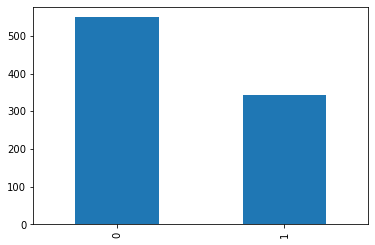

In [6]:
titanic["Survived"].value_counts().plot.bar()

# Preprocess data

In [7]:
X = titanic[["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch"]]
y = titanic["Survived"]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
X_train.shape, X_val.shape

((668, 6), (223, 6))

In [9]:
column_trans = ColumnTransformer(
    [
        ('Pclass', OneHotEncoder(dtype='int'),['Pclass']),
        ('Sex', OneHotEncoder(dtype='int'),['Sex']),
        ('Age', SimpleImputer(strategy="median"), ['Age']),
        ('Fare', SimpleImputer(strategy="median"), ['Fare']),
        ('SibSp', SimpleImputer(strategy="median"), ['SibSp']),
        ('Parch', SimpleImputer(strategy="median"), ['Parch'])
    ],
    remainder='drop').fit(X_train)
X_train = column_trans.transform(X_train)
X_val = column_trans.transform(X_val)

In [10]:
feature_names = []
for tr in column_trans.transformers_:
    if hasattr(tr[1], "get_feature_names"):
        features = [f"{tr[0]}_{c[3:]}" for c in tr[1].get_feature_names()]
        feature_names += features
    else:
        feature_names.append(tr[0])
feature_names

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Age',
 'Fare',
 'SibSp',
 'Parch']

In [11]:
X_train = pd.DataFrame(X_train, columns=feature_names)
X_val = pd.DataFrame(X_val, columns=feature_names)

In [12]:
X_train.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,28.0,7.8958,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,17.0,7.9250,4.0,2.0
2,0.0,0.0,1.0,0.0,1.0,30.0,16.1000,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,22.0,7.2500,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,45.0,13.5000,0.0,0.0


In [13]:
X_val.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Fare,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,29.0,14.4583,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,29.0,7.5500,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,7.0,29.1250,4.0,1.0
3,1.0,0.0,0.0,1.0,0.0,29.0,146.5208,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0,29.0,15.2458,0.0,2.0


# Train model

In [14]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=0,
    class_weight="balanced")
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0)

In [15]:
y_val_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

In [16]:
val_auc = roc_auc_score(y_val, y_val_prob)
print(f'Val AUC={val_auc}')

Val AUC=0.8878040424803014


In [17]:
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Val ACC={val_acc}')

Val ACC=0.8026905829596412


(array([71., 30., 10., 31.,  3.,  4., 33.,  1.,  5., 35.]),
 array([0.16704545, 0.24541934, 0.32379323, 0.40216711, 0.480541  ,
        0.55891489, 0.63728878, 0.71566267, 0.79403655, 0.87241044,
        0.95078433]),
 <BarContainer object of 10 artists>)

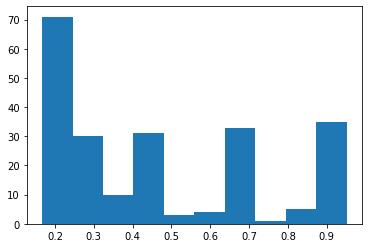

In [18]:
plt.hist(y_val_prob)

# PDP for Fare (Numerical)

In [19]:
pdp_fare = pdp.pdp_isolate(
    model=model, dataset=X_val, model_features=X_val.columns.tolist(), feature='Fare'
)

In [20]:
pdp_fare.hist_data

array([ 14.4583,   7.55  ,  29.125 , 146.5208,  15.2458,  30.5   ,
       153.4625, 164.8667,  91.0792,   7.2292,   7.8542,  13.    ,
         7.75  ,  26.25  ,  83.1583,   7.8542,   9.225 ,  36.75  ,
         8.05  ,   8.5167,  11.5   , 151.55  ,   7.7375,  31.    ,
         9.8375, 134.5   ,   7.8958,   7.75  ,  26.    ,  27.9   ,
         8.6625,  10.5   ,   9.5   ,  35.5   ,   7.0458,  30.5   ,
         6.45  ,  10.5   ,  13.    ,  14.    ,  79.2   ,   7.225 ,
        14.5   ,  39.6875,  83.475 ,   7.8958,   7.8958, 262.375 ,
        13.    ,  79.65  ,  30.    ,  63.3583,  23.    ,   7.8958,
        29.7   ,  73.5   ,  26.55  ,  31.275 ,  27.9   ,  23.25  ,
         7.2292,  21.075 ,  78.2667,  39.6   ,  11.1333,   7.75  ,
        25.9292,  33.    ,  26.    ,  30.    ,  26.    ,  52.    ,
        82.1708,   8.05  ,   8.05  ,  21.    , 263.    ,  27.7208,
         6.4958,  15.05  ,  24.15  ,  15.9   ,  26.    ,   7.775 ,
        26.    ,  77.9583, 227.525 ,   9.5875,  10.5   , 108.9

In [21]:
pdp_fare.count_data

,x,xticklabels,count,count_norm
0,0,"[0, 7.62)",25,0.112108
1,1,"[7.62, 7.9)",24,0.107623
2,2,"[7.9, 8.46)",25,0.112108
3,3,"[8.46, 11.13)",24,0.107623
4,4,"[11.13, 15.25)",24,0.107623
5,5,"[15.25, 26)",19,0.085202
6,6,"[26, 31.18)",32,0.143498
7,7,"[31.18, 77.14)",25,0.112108
8,8,"[77.14, 263]",25,0.112108


In [22]:
pdp_fare.pdp

array([0.41805241, 0.41974907, 0.42206073, 0.42974392, 0.44812666,
       0.45993422, 0.46288665, 0.4898869 , 0.50165985, 0.50220956])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


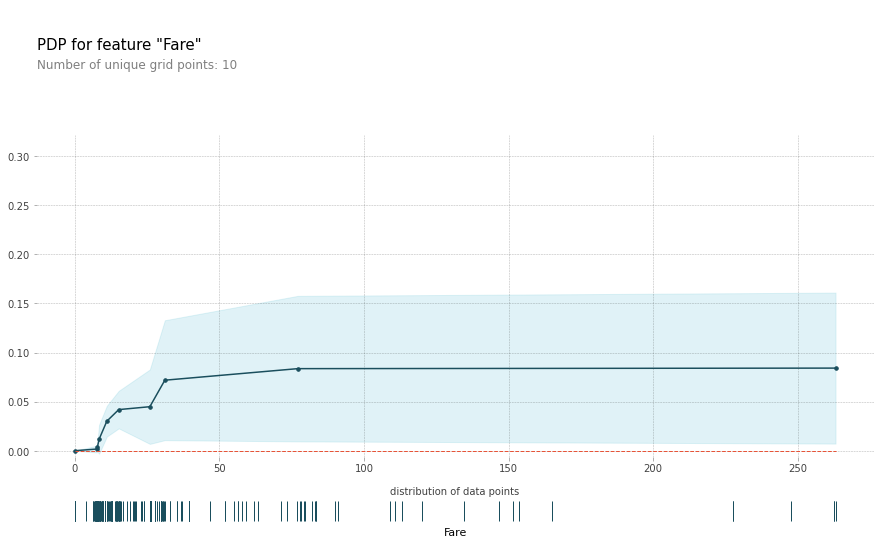

In [23]:
fig, axes = pdp.pdp_plot(pdp_fare, "Fare", plot_pts_dist=True)

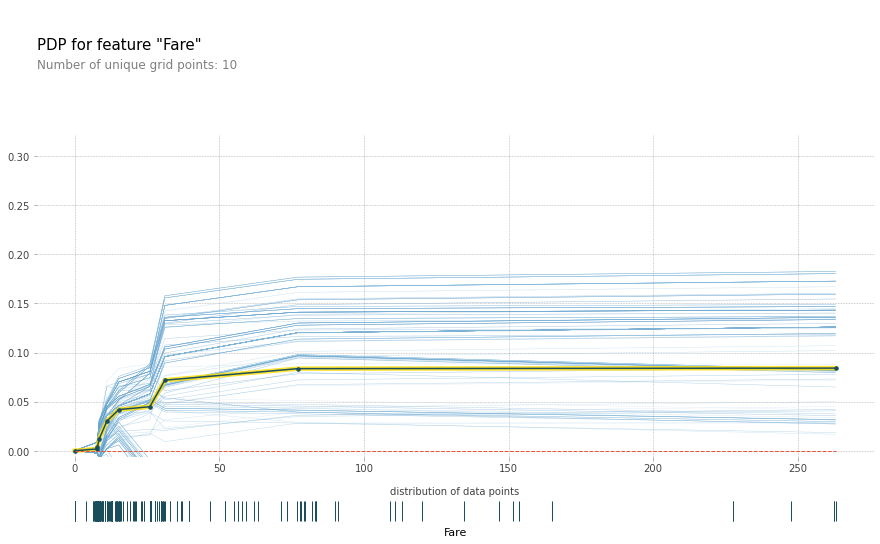

In [24]:
fig, axes = pdp.pdp_plot(pdp_fare, "Fare", plot_pts_dist=True, plot_lines=True)

# PDP for Pclass (Categorical)

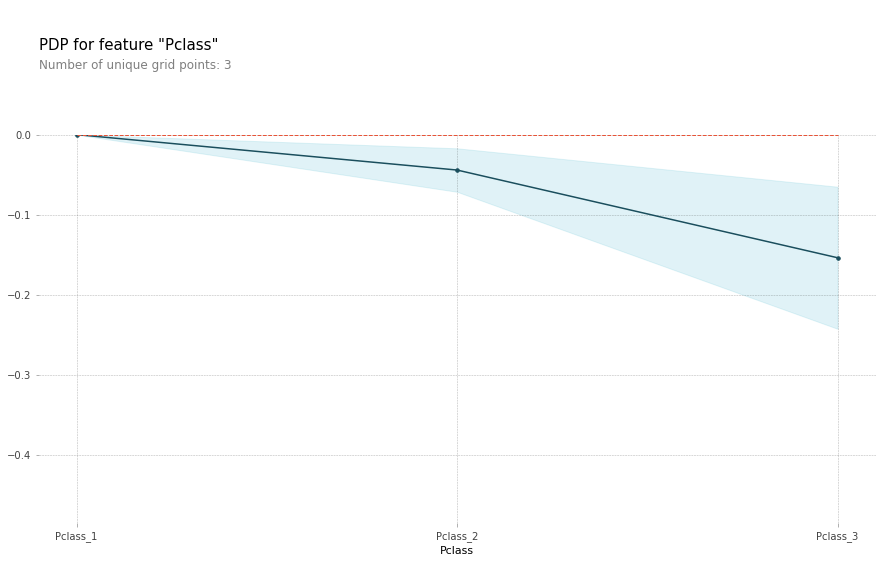

In [25]:
pdp_pclass = pdp.pdp_isolate(
    model=model, dataset=X_val, model_features=X_val.columns.tolist(), feature=['Pclass_1', 'Pclass_2', 'Pclass_3']
)
fig, axes = pdp.pdp_plot(pdp_pclass, "Pclass")

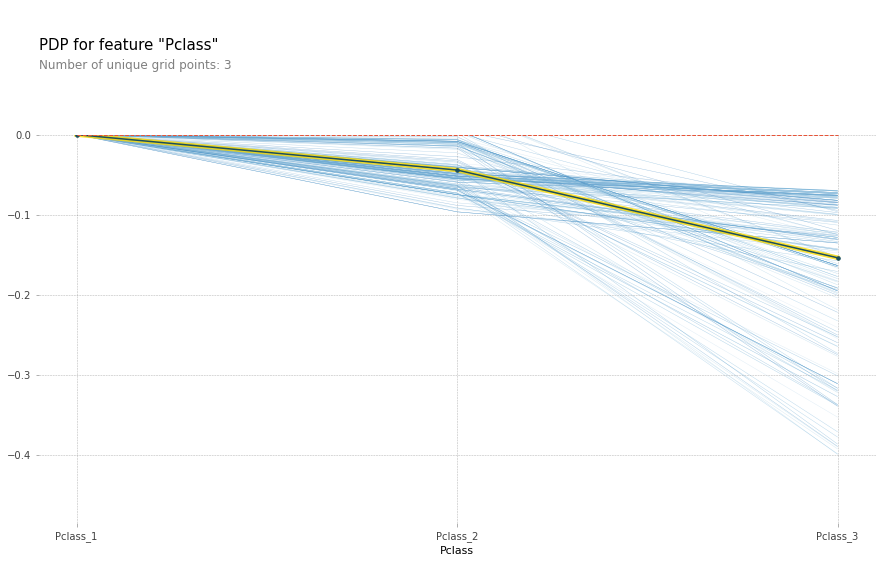

In [26]:
pdp_pclass = pdp.pdp_isolate(
    model=model, dataset=X_val, model_features=X_val.columns.tolist(), feature=['Pclass_1', 'Pclass_2', 'Pclass_3']
)
fig, axes = pdp.pdp_plot(pdp_pclass, "Pclass", plot_lines=True)

## Extract PDP data

In [27]:
pdp_pclass.count_data

,index,count,x,count_norm
0,Pclass_1,53.0,0,0.237668
1,Pclass_2,46.0,1,0.206278
2,Pclass_3,124.0,2,0.556054


In [28]:
pdp_pclass.ice_lines

,Pclass_1,Pclass_2,Pclass_3
0,0.324042,0.283201,0.241944
1,0.271345,0.217618,0.195054
2,0.545255,0.505181,0.353970
3,0.948223,0.877820,0.636765
4,0.868062,0.874205,0.672759
...,...,...,...
218,0.882201,0.872412,0.544799
219,0.948016,0.878731,0.636765
220,0.277264,0.222175,0.201537
221,0.915672,0.841964,0.588236
